<a href="https://colab.research.google.com/github/gool626/Bidule/blob/main/Complete_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 292 kB 10.0 MB/s 
     |████████████████████████████████| 45 kB 3.8 MB/s 
     |████████████████████████████████| 106 kB 64.5 MB/s 


In [5]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=9a14ae9c1c9d01b59b537e328840e1d2c62d996d19a8be36ef69d92e84b13e82
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [6]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 4.5 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=50036344470c1fd0ba174e0b7e942f809b4b17005ea192f996c03efabbc8bc2e
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


<h1>Import Dataset</h1>

In [7]:
import pandas as pd
from binance.client import Client
import ta
import pandas_ta as pda
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored


client = Client()

klinesT = client.get_historical_klines("BNBBUSD", Client.KLINE_INTERVAL_1HOUR, "01 january 2021")

df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']
print(df)

# ----- Functions Definition -------
def get_chop(high, low, close, window):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(window).max()
    lowl = low.rolling(window).min()
    ci = 100 * np.log10((atr.rolling(window).sum()) / (highh - lowl)) / np.log10(window)
    return ci

                        open     high      low    close          volume  \
timestamp                                                                 
2021-01-01 00:00:00   736.42   739.00   729.33   734.07  27932.69884000   
2021-01-01 01:00:00   734.08   749.00   733.37   748.28  52336.18779000   
2021-01-01 02:00:00   748.27   749.00   742.27   744.06  33019.50100000   
2021-01-01 03:00:00   744.06   747.23   743.10   744.82  17604.80859000   
2021-01-01 04:00:00   744.87   747.09   739.30   742.29  18794.15424000   
...                      ...      ...      ...      ...             ...   
2022-11-24 04:00:00  1201.93  1205.94  1198.74  1203.25  16121.97880000   
2022-11-24 05:00:00  1203.25  1205.47  1199.63  1200.88  15479.65450000   
2022-11-24 06:00:00  1200.88  1217.05  1199.48  1214.01  37986.48010000   
2022-11-24 07:00:00  1214.00  1217.71  1206.26  1206.72  39850.44870000   
2022-11-24 08:00:00  1206.72  1208.35  1200.00  1203.00  11885.11070000   

                        

<h1>Backtest Execution</h1>

In [8]:
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

#Simple Moving Average
df['SMA']=ta.trend.sma_indicator(df['close'], window=12)

#Exponential Moving Average
df['EMA1']=ta.trend.ema_indicator(close=df['close'], window=13)
df['EMA2']=ta.trend.ema_indicator(close=df['close'], window=38)

# #Relative Strength Index (RSI)
df['RSI']=ta.momentum.rsi(close=df['close'], window=14)

# #MACD
MACD = ta.trend.MACD(close=df['close'], window_fast=12, window_slow=26, window_sign=9)
df['MACD'] = MACD.macd()
df['MACD_SIGNAL'] = MACD.macd_signal()
df['MACD_DIFF'] = MACD.macd_diff() #Histogramme MACD

# #Ichimoku
df['KIJUN'] = ta.trend.ichimoku_base_line(high=df['high'], low=df['low'], window1=9, window2=26)
df['TENKAN'] = ta.trend.ichimoku_conversion_line(high=df['high'], low=df['low'], window1=9, window2=26)
df['SSA'] = ta.trend.ichimoku_a(high=df['high'], low=df['low'], window1=9, window2=26)
df['SSB'] = ta.trend.ichimoku_b(high=df['high'], low=df['low'], window2=26, window3=52)


df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,open,high,low,close,volume,SMA,EMA1,EMA2,RSI,MACD,MACD_SIGNAL,MACD_DIFF,KIJUN,TENKAN,SSA,SSB,BOL_H_BAND,BOL_L_BAND,BOL_MAVG_BAND
timestamp,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,736.42,739.00,729.33,734.07,27932.69884000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.165,NaN,NaN,NaN
2021-01-01 01:00:00,734.08,749.00,733.37,748.28,52336.18779000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,739.165,NaN,NaN,NaN
2021-01-01 02:00:00,748.27,749.00,742.27,744.06,33019.50100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,739.165,NaN,NaN,NaN
2021-01-01 03:00:00,744.06,747.23,743.10,744.82,17604.80859000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,739.165,NaN,NaN,NaN
2021-01-01 04:00:00,744.87,747.09,739.30,742.29,18794.15424000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,739.165,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24 04:00:00,1201.93,1205.94,1198.74,1203.25,16121.97880000,1182.279167,1185.017055,1164.047461,69.315391,14.204416,11.788682,2.415735,1180.300,1184.995,1182.6475,1142.500,1206.399797,1144.180203,1175.2900
2022-11-24 05:00:00,1203.25,1205.47,1199.63,1200.88,15479.65450000,1186.177500,1187.283190,1165.936310,67.388013,14.318879,12.294721,2.024157,1180.300,1189.075,1184.6875,1142.500,1209.749092,1144.220908,1176.9850
2022-11-24 06:00:00,1200.88,1217.05,1199.48,1214.01,37986.48010000,1189.817500,1191.101306,1168.401627,72.028412,15.292786,12.894334,2.398452,1183.825,1192.600,1188.2125,1146.025,1215.438712,1142.474288,1178.9565


<h1>Spot Backtest</h1>

Period : [2021-01-01 00:00:00] -> [2022-11-24 08:00:00]
Starting balance : 1000 $
Final balance : 1457.45 $
Performance vs US Dollar : 45.74 %
Buy and Hold Performence : 63.88 %
Performance vs Buy and Hold : -28.39 %
Number of negative trades :  166
Number of positive trades :  58
Average Positive Trades :  6.31 %
Average Negative Trades :  -1.77 %
Best trade +9.95 %, the  2022-08-13 06:00:00
Worst trade -2.05 %, the  2021-05-30 22:00:00
Worst drawBack -49.0 %
Total fee :  558.8 $
Buy Market number : 225
Sell Stop Loss number : 120
Sell Take Profit number : 32
Sell Market number : 72
PLOT


,date,position,reason,price,frais,fiat,coins,wallet,drawBack,resultat,resultat%,tradeIs
date,,,,,,,,,,,,
2021-01-02 13:00:00,2021-01-02 13:00:00,Buy,Buy Market,770.7700,0.700000,0,1.296496,999.300000,0.000000,NaN,NaN,
2021-01-02 14:00:00,2021-01-02 14:00:00,Sell,Sell Stop Loss,755.3546,0.489657,978.824343,0.000000,978.824343,-0.020490,-20.475657,-2.049000,Bad
2021-01-09 08:00:00,2021-01-09 08:00:00,Buy,Buy Market,1208.0100,0.685177,0,0.809711,978.139166,-0.021176,NaN,NaN,
2021-01-10 01:00:00,2021-01-10 01:00:00,Sell,Sell Take Profit,1328.8110,0.537977,1075.415106,0.000000,1075.415106,0.000000,97.275940,9.945000,Good
2021-01-13 19:00:00,2021-01-13 19:00:00,Buy,Buy Market,1102.0800,0.752791,0,0.975122,1074.662315,-0.000700,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18 06:00:00,2022-11-18 06:00:00,Buy,Buy Market,1218.5500,1.054078,0,1.234887,1504.771663,-0.475864,NaN,NaN,
2022-11-18 16:00:00,2022-11-18 16:00:00,Sell,Sell Market,1207.4500,1.043745,1490.020671,0.000000,1490.020671,-0.481002,-14.750992,-0.980281,Bad
2022-11-19 22:00:00,2022-11-19 22:00:00,Buy,Buy Market,1224.1900,1.043014,0,1.216296,1488.977656,-0.481365,NaN,NaN,


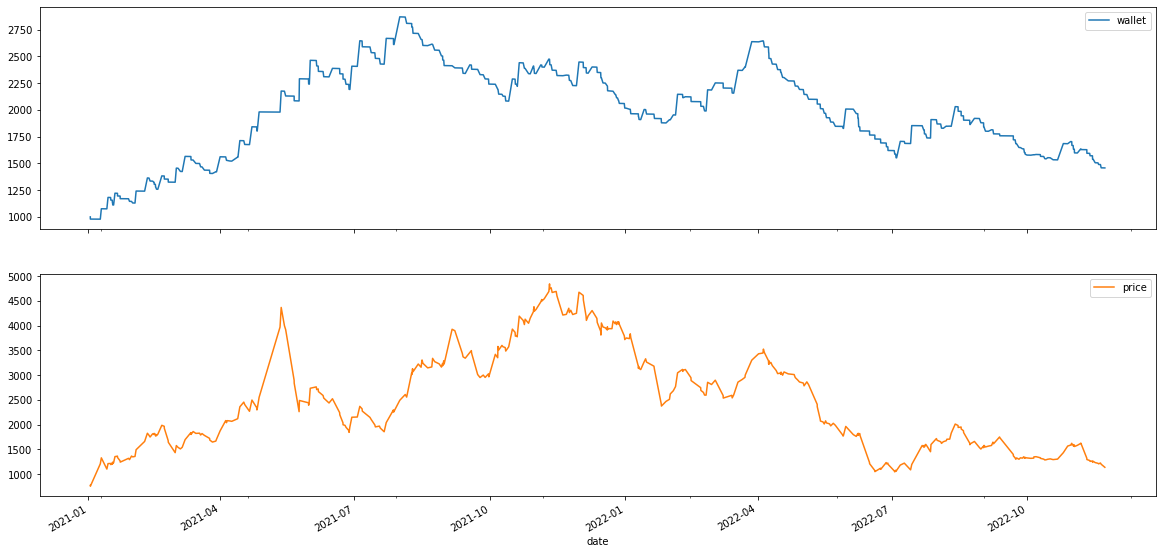

In [10]:
dfTest = df.copy()
# dfTest = df['2021-01-01':]
dt = None
dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 1000
initalWallet = usdt
coin = 0
wallet = 1000
lastAth = 0
previousRow = dfTest.iloc[0]
makerFee = 0.0005
takerFee = 0.0007
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True

def buyCondition(row, previousRow):
  if row['EMA1'] > row['EMA2']:
    return True
  else:
    return False

  
def sellCondition(row, previousRow):
  if row['EMA2'] > row['EMA1']:
    return True
  else:
    return False


for index, row in dfTest.iterrows():
  #Buy market order
  if buyCondition(row, previousRow) == True and usdt > 0 and buyReady == True:
    #You can define here at what price you buy
    buyPrice = row['close']

    #Define the price of you SL and TP or comment it if you don't want a SL or TP
    stopLoss = buyPrice - 0.02 * buyPrice
    takeProfit = buyPrice + 0.1 * buyPrice

    coin = usdt / buyPrice
    fee = takerFee * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
      lastAth = wallet

    # print("Buy COIN at",buyPrice,'$ the', index)
    myrow = {'date': index,'position': "Buy", 'reason': 'Buy Market','price': buyPrice,'frais': fee*row['close'],'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  #Stop Loss
  elif row['low'] < stopLoss and coin > 0:

    sellPrice = stopLoss

    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell", 'reason': 'Sell Stop Loss', 'price': sellPrice, 'frais': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

  #Take Profit
  elif row['high'] > takeProfit and coin > 0:

    sellPrice = takeProfit

    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at Take Profit Loss",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell", 'reason': 'Sell Take Profit', 'price': sellPrice, 'frais': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)     

  # Sell Market
  elif sellCondition(row, previousRow) == True:
    buyReady = True
    if coin > 0 and sellReady == True:
      sellPrice = row['close']
      usdt = coin * sellPrice
      frais = takerFee * usdt
      usdt = usdt - frais
      coin = 0
      wallet = usdt
      if wallet > lastAth:
        lastAth = wallet
      # print("Sell COIN at",sellPrice,'$ the', index)
      myrow = {'date': index,'position': "Sell", 'reason': 'Sell Market', 'price': sellPrice, 'frais': frais, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
      dt = dt.append(myrow,ignore_index=True)
  
  previousRow = row

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 1000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")
reasons = dt['reason'].unique()
for r in reasons:
  print(r+" number :",dt.groupby('reason')['date'].nunique()[r])

dt[['wallet','price']].plot(subplots=True, figsize=(20,10))
print('PLOT')
dt

In [ ]:
Comming Soon....